In [1]:
import tensorflow as tf
import os
import numpy as np
from PIL import Image
import cv2
from IPython.display import display
import time
import pickle
from skimage.exposure import match_histograms

#from object_detection.utils import label_map_util
#from object_detection.utils import visualization_utils as vis_util
tf.gfile = tf.io.gfile

from tensorflow.keras.models import model_from_json

%run ./utils/object_detection_utils.ipynb
%run ./utils/image_utils.ipynb
%run ./utils/data_utils.ipynb
%run utils.ipynb

#ROOT = "/mnt/nvme-storage/pfauregi"
ROOT = "/mnt/balrog/pfauregi"

# Detection

In [2]:
detection_model_path = os.path.join(ROOT,"training/obj_detection/ws_bd/models/model/export/saved_model/")
labels_path = os.path.join(ROOT,"artificial_datasets/dataset01_tfr/binary_label_map.pbtxt")

In [3]:
def run_detection(model_path, sample):
    start = time.time()
    model = tf.saved_model.load(model_path)
    model = model.signatures['serving_default']
    detection_results = run_inference_for_single_image(model, sample)
    print("Detection processed in", time.time()-start, "s!")
    return detection_results

def get_thumbails_batch(sample, detection, score_thresold=0.5, verbose=False, ref_img=None):
    thumbails = {}
    thumbails["batch"] = []
    thumbails["bounding_box"] = []
    thumbails["score"] = []
    image_detections = sample.copy()
    height, width, channels = image_detections.shape
    for box, score in zip(detection['detection_boxes'], detection['detection_scores']):
        if score>score_thresold:
            ymin, xmin, ymax, xmax = int(box[0]*height), int(box[1]*width), int(box[2]*height), int(box[3]*width)
            if verbose: image_detections = cv2.rectangle(image_detections, (xmin, ymin), (xmax, ymax), (255, 0, 0), 4)
            thumbail = sample[ymin:ymax, xmin:xmax, 0]
            if not ref_img is None: thumbail = match_histograms(thumbail, ref_img, multichannel=False).astype("uint8")
            thumbail = convert_to_square(thumbail, new_size=256)
            thumbail = np.repeat(thumbail[:, :, np.newaxis], 3, axis=2)
            thumbails["batch"].append(thumbail)
            thumbails["bounding_box"].append([ymin, xmin, ymax, xmax])
            thumbails["score"].append(score)
    thumbails["batch"] = np.array(thumbails["batch"]).astype('float32')/255
    if verbose: 
        display(Image.fromarray(image_detections).resize((int(0.2*width), int(0.2*height))))
        display(Image.fromarray((thumbails["batch"][2]*255).astype('uint8')))
        thumbails["batch"][1].shape[0]
    return thumbails

# Classification

In [4]:
#class_root = os.path.join(ROOT,"training/thumbails/saved_models/normalized_model")
class_root = os.path.join(ROOT,"training/thumbails/saved_models/unnorm_model")
class_model_path = os.path.join(class_root, "model.json")
class_model_weights_path = os.path.join(class_root, "model.h5")
id_map_inv = get_selected_taxons(os.path.join(class_root, "model_id_map.csv"), inv=True)
ref_img = cv2.imread(os.path.join(class_root, "ref_img.png"), cv2.IMREAD_GRAYSCALE)

In [5]:
def run_classification(class_model_path, class_model_weights, thumbails_batch):
    json_file = open(class_model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(class_model_weights)
    loaded_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    out = loaded_model.predict(thumbails_batch, batch_size=thumbails_batch.shape[0], use_multiprocessing=True)
    return out

def draw_classif(sample, thumbails, inv_id_map, class_score_thresold=0.4, image_scale = 0.4, text_scale = 1):
    image_detections = sample.copy()
    for bb, label, score in zip(thumbails["bounding_box"], thumbails["labels"], thumbails["score"]):
        if np.max(label)>=0.5:
            if np.max(label) < class_score_thresold:
                label_text = "not sure"
            else:
                label_text = inv_id_map[np.argmax(label)]

            color = (255, 0, 0)
            font = cv2.FONT_HERSHEY_SIMPLEX
            ymin, xmin, ymax, xmax = bb
            cv2.rectangle(image_detections, (xmin, ymin), (xmax, ymax), color, 4)
            cv2.putText(image_detections,  label_text, (xmin, ymin+int(text_scale*80)), font, text_scale*3, color, 4, cv2.LINE_AA) 
            cv2.putText(image_detections,  "Detect: "+str(score), (xmin+5, ymin+int(text_scale*120)), font, text_scale*1, color, 1, cv2.LINE_AA) 
            cv2.putText(image_detections,  "Classif: "+str(np.max(label)), (xmin+5, ymin+int(text_scale*160)), font, text_scale*1, color, 1, cv2.LINE_AA) 
    height, width, channels = image_detections.shape
    display(Image.fromarray(image_detections).resize((int(image_scale*width), int(image_scale*height))))
    return image_detections

# Full pipeline

In [6]:
path = os.path.join(ROOT,"datasets/micro_samples/")
#path = "/mnt/nvme-storage/pfauregi/artificial_datasets/dataset03/images"
onlyfiles = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
img_path = os.path.join(ROOT,"artificial_datasets/dataset03/images/00040.png")

In [7]:
print(onlyfiles)
print(img_path)

['sample_08.jpg', 'sample_10.jpg', 'sample_03.tiff', 'sample_04.tiff', 'sample_07.jpg', 'sample_02.tiff', 'sample_06.tiff', 'sample_05.tiff', 'adct.png', 'sample_01.tiff', 'sample_09.jpg']
/mnt/balrog/pfauregi/artificial_datasets/dataset03/images/00040.png


2
uint8
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Detection processed in 11.484302997589111 s!


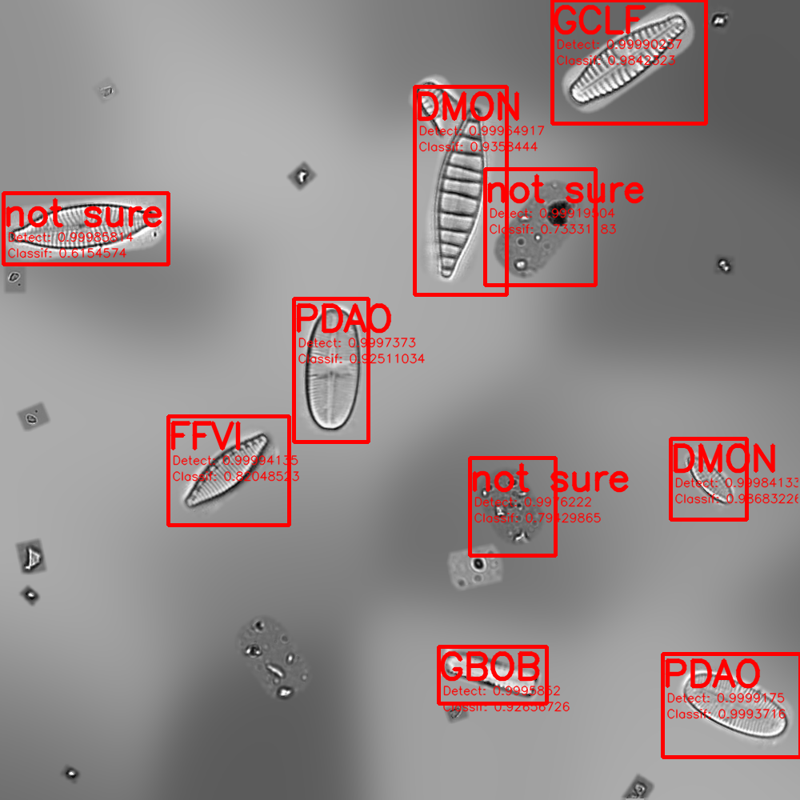

In [8]:
#sample = load_image(os.path.join(path, onlyfiles[3]), expand = False)
sample = load_image(img_path, expand = False)
print(sample.ndim)
print(sample.dtype)
sample = expand(sample)
#display(Image.fromarray(sample))
# Detection
detection_results = run_detection(detection_model_path, sample)
thumbails = get_thumbails_batch(sample, detection_results, score_thresold=0.99, verbose=False, ref_img=None)

# Classification
thumbails["labels"] = run_classification(class_model_path, class_model_weights_path, thumbails["batch"])
final_image = draw_classif(sample, thumbails, id_map_inv, image_scale=0.8, text_scale=0.5, class_score_thresold=0.8)

In [35]:
cv2.imwrite("./test.png", final_image)

True

In [13]:
os.path.join(ROOT, "tmp/", (str(i)+".png"))

'/mnt/balrog/pfauregi/tmp/10.png'

In [16]:
for i, thumbail in enumerate(thumbails["batch"]):
    np_img = (thumbail*255).astype('uint8')
    save_path = os.path.join(ROOT, "tmp/", (str(i)+".png"))
    cv2.imwrite(save_path, np_img)
    print("Saved in:", save_path)

Saved in: /mnt/balrog/pfauregi/tmp/0.png
Saved in: /mnt/balrog/pfauregi/tmp/1.png
Saved in: /mnt/balrog/pfauregi/tmp/2.png
Saved in: /mnt/balrog/pfauregi/tmp/3.png
Saved in: /mnt/balrog/pfauregi/tmp/4.png
Saved in: /mnt/balrog/pfauregi/tmp/5.png
Saved in: /mnt/balrog/pfauregi/tmp/6.png
Saved in: /mnt/balrog/pfauregi/tmp/7.png
Saved in: /mnt/balrog/pfauregi/tmp/8.png
Saved in: /mnt/balrog/pfauregi/tmp/9.png
Saved in: /mnt/balrog/pfauregi/tmp/10.png


2
uint8


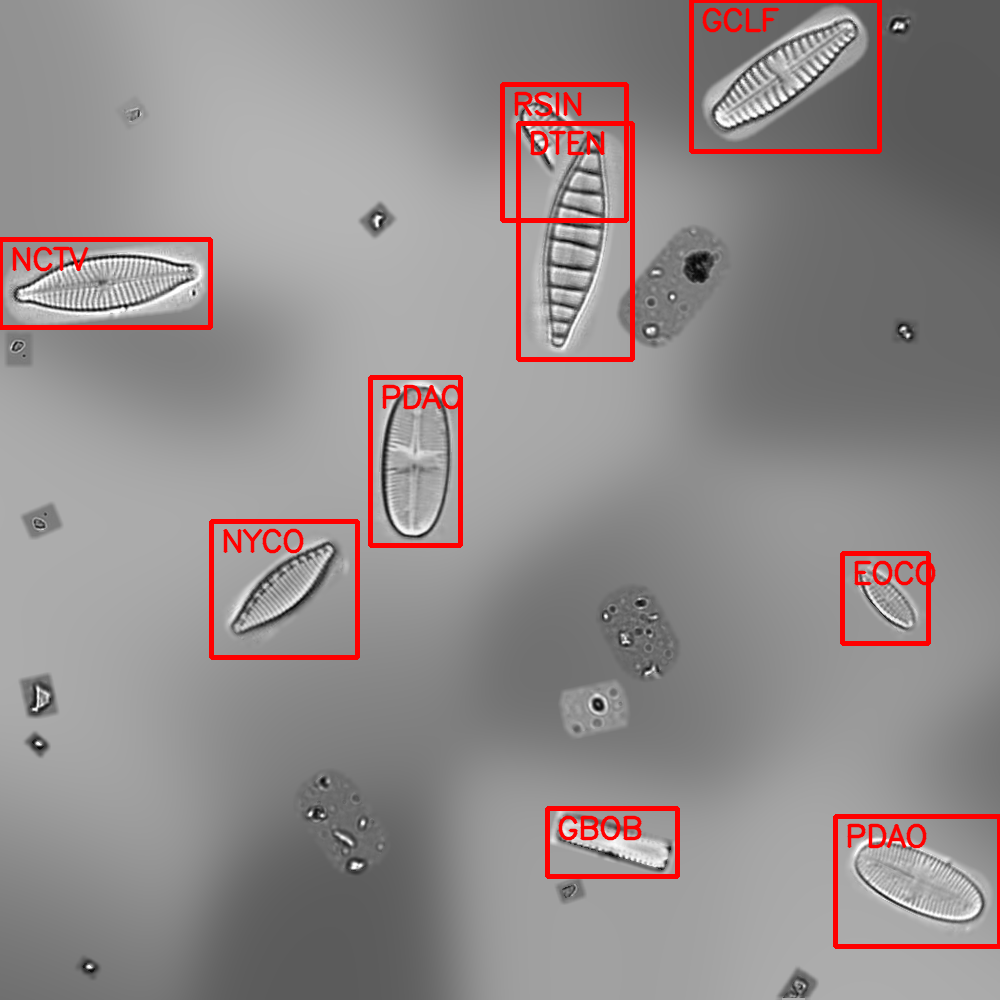

In [22]:
annot = pickle.load( open( os.path.join(ROOT,"artificial_datasets/dataset03/annotations/bb_00040.pickle"), "rb" ) )
img_path = os.path.join(ROOT,"artificial_datasets/dataset03/",annot['img_path'])
sample = load_image(img_path, expand = False)
print(sample.ndim)
print(sample.dtype)
sample = expand(sample)

for annotation in annot["labels"]:
    color = (255, 0, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    ymin, xmin, ymax, xmax = annotation["xmin"], annotation["ymin"], annotation["xmax"], annotation["ymax"]
    label_text = annotation["taxon"]
    cv2.rectangle(sample, (xmin, ymin), (xmax, ymax), color, 4)
    cv2.putText(sample,  label_text, (xmin+10, ymin+30), font, 1, color, 2, cv2.LINE_AA)

display(Image.fromarray(sample))